# Counterfactuals guided by prototypes on MNIST

This method is described in the [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584) paper and can generate counterfactual instances guided by class prototypes. It means that for a certain instance X, the method builds a prototype for each prediction class using either an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) or [k-d trees](https://en.wikipedia.org/wiki/K-d_tree). The nearest prototype class other than the originally predicted class is then used to guide the counterfactual search. For example, in MNIST the closest class to a 7 could be a 9. As a result, the prototype loss term will try to minimize the distance between the proposed counterfactual and the prototype of a 9. This speeds up the search towards a satisfactory counterfactual by steering it towards an interpretable solution from the start of the optimization. It also helps to avoid out-of-distribution counterfactuals with the perturbations driven to a prototype of another class.

The loss function to be optimized is the following: 

$Loss$ = c$L_{pred}$ + $\beta$$L_{1}$ + $L_{2}$ + $L_{AE}$ + $L_{proto}$

The first loss term relates to the model's prediction function, the following 2 terms define the elastic net regularization while the last 2 terms are optional. The aim of $L_{AE}$ is to penalize out-of-distribution counterfactuals while $L_{proto}$ guides the counterfactual to a prototype. When we only have acces to the model's prediction function and cannot fully enjoy the benefits of automatic differentiation, the prototypes allow us to drop the prediction function loss term $L_{pred}$ and still generate high quality counterfactuals. This drastically reduces the number of prediction calls made during the numerical gradient update step and again speeds up the search.

Other options include generating counterfactuals for specific classes or including trust score constraints to ensure that the counterfactual is close enough to the newly predicted class compared to the original class. Different use cases are illustrated throughout this notebook.

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto

## Load and prepare MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


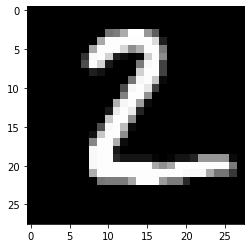

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

Prepare data: scale, reshape and categorize

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [5]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5', save_format='h5')

Evaluate the model on test set

In [7]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9887


## Define and train auto-encoder

In [8]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [9]:
ae, enc, dec = ae_model()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')
enc.save('mnist_enc.h5', save_format='h5')

Compare original with decoded images

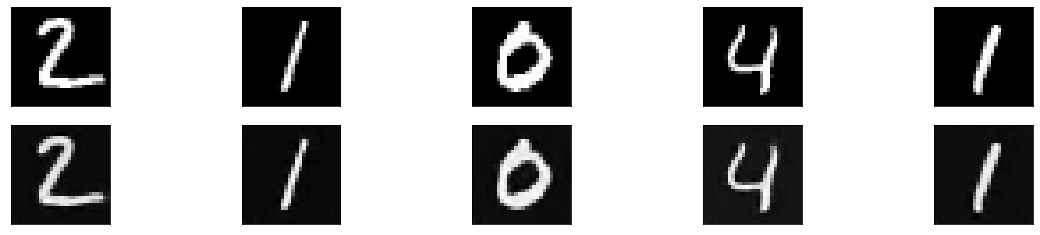

In [10]:
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5', compile=False)

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generate counterfactual guided by the nearest class prototype

Original instance:

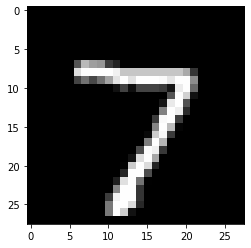

In [11]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

Counterfactual parameters:

In [12]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

Run counterfactual:

In [25]:
# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 10.619 sec
Explanation took 8.659 sec


Results:

Counterfactual prediction: 9
Closest prototype class: 9


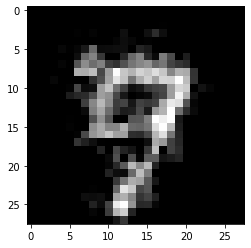

In [26]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28));

The counterfactual starting from a 7 moves towards its closest prototype class: a 9. The evolution of the counterfactual during the first iteration can be seen below:

iteration c 0


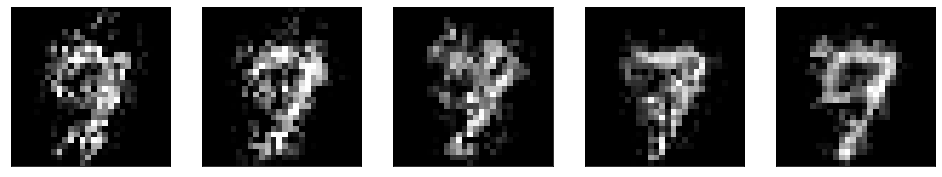

In [28]:
iter_cf = 0
print('iteration c {}'.format(iter_cf))
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Typically, the first few iterations already steer the 7 towards a 9, while the later iterations make the counterfactual more sparse.

## Prototypes defined by the $k$ nearest encoded instances

In the above example, the class prototypes are defined by the average encoding of all instances belonging to the specific class. Instead, we can also select only the $k$ nearest encoded instances of a class to the encoded instance to be explained and use the average over those $k$ encodings as the prototype.

In [29]:
# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

Results for $k$ equals 1:

Counterfactual prediction: 9
Closest prototype class: 9


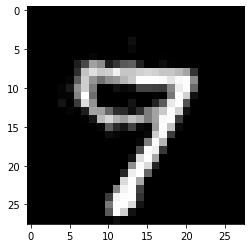

In [30]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation_k1.cf['X'].reshape(28, 28));

Results for $k$ equals 20:

Counterfactual prediction: 9
Closest prototype class: 9


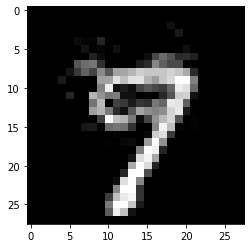

In [31]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation_k20.cf['X'].reshape(28, 28));

A lower value of $k$ typically leads to counterfactuals that look more like the original instance and less like an average instance of the counterfactual class.

## Remove the autoencoder loss term $L_{AE}$

In the previous example, we used both an autoencoder loss term to penalize a counterfactual which falls outside of the training data distribution as well as an encoder loss term to guide the counterfactual to the nearest prototype class. In the next example we get rid of the autoencoder loss term to speed up the counterfactual search and still generate decent counterfactuals:

In [32]:
# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 6.284 sec


Results:

Counterfactual prediction: 9
Closest prototype class: 9


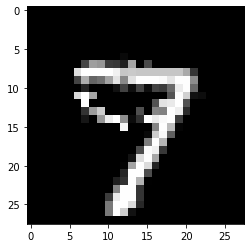

In [33]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28));

## Specify prototype classes

For multi-class predictions, we might be interested to generate counterfactuals for certain classes while avoiding others. The following example illustrates how to do this:

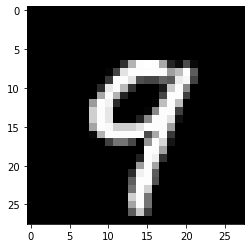

In [34]:
X = x_test[12].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28));

In [35]:
# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_1 = cf.explain(X, k=5, k_type='mean')
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[7])
proto_2 = explanation_2.id_proto

The closest class to the 9 is 4. This is evident by looking at the first counterfactual below. For the second counterfactual, we specified that the prototype class used in the search should be a 7. As a result, a counterfactual 7 instead of a 4 is generated.

Counterfactual prediction: 4
Closest prototype class: 4


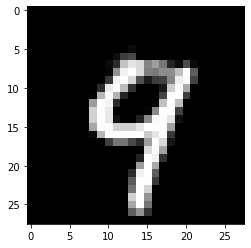

In [36]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print('Closest prototype class: {}'.format(proto_1))
plt.imshow(explanation_1.cf['X'].reshape(28, 28));

Counterfactual prediction: 7
Closest prototype class: 7


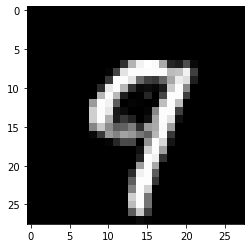

In [37]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print('Closest prototype class: {}'.format(proto_2))
plt.imshow(explanation_2.cf['X'].reshape(28, 28));

## Speed up the counterfactual search by removing the predict function loss term

We can also remove the prediction loss term and still obtain an interpretable counterfactual. This is especially relevant for fully black box models. When we provide the counterfactual search method with a Keras or TensorFlow model, it is incorporated in the TensorFlow graph and evaluated using automatic differentiation. However, if we only have access to the model's prediction function, the gradient updates are numerical and typically require a large number of prediction calls because of the prediction loss term $L_{pred}$. These prediction calls can slow the search down significantly and become a bottleneck. We can represent the gradient of the loss term as follows:

\begin{equation*} \frac{\partial L_{pred}}{\partial x} = \frac{\partial L_{pred}}{\partial p} \frac{\partial p}{\partial x} \end{equation*}

where $L_{pred}$ is the prediction loss term, $p$ the prediction function and $x$ the input features to optimize. For a 28 by 28 MNIST image, the $^{\delta p}/_{\delta x}$ term alone would require a prediction call with batch size 28x28x2 = 1568. By using the prototypes to guide the search however, we can remove the prediction loss term and only make a single prediction at the end of each gradient update to check whether the predicted class on the proposed counterfactual is different from the original class. We do not necessarily need a Keras or TensorFlow auto-encoder either and can use k-d trees to find the nearest class prototypes. Please check out [this notebook](./cfproto_housing.ipynb) for a practical example.

The first example below removes $L_{pred}$ from the loss function to bypass the bottleneck. It illustrates the drastic speed improvements over the black box alternative with numerical gradient evaluation while still producing interpretable counterfactual instances.

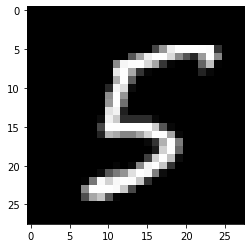

In [38]:
plt.gray()
X = x_test[23].reshape(1, 28, 28, 1)
plt.imshow(X.reshape(28, 28));

In [39]:
c_init = 0.  # weight on prediction loss term set to 0
c_steps = 1  # no need to find optimal values for c

In [40]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 6.271 sec


Counterfactual prediction: 6
Closest prototype class: 6


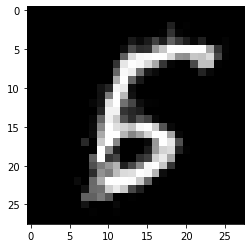

In [41]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28));

Let us know add the $L_{pred}$ loss term back in the objective function and observe how long it takes to generate a black box counterfactual:

In [42]:
c_init = 1.
c_steps = 2

In [43]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 545.836 sec


Counterfactual prediction: 6
Closest prototype class: 6


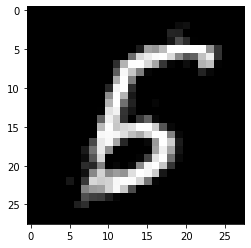

In [44]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28));

Clean up:

In [32]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')
os.remove('mnist_enc.h5')